In [11]:
from keras import Model
from keras.callbacks import EarlyStopping

from utility import format_missing_values, features_selection, preprocessing_text

from tqdm import tqdm
import pandas as pd
import numpy as np
tqdm.pandas()

from sklearn import metrics
from sklearn.utils import shuffle
from joblib import dump

import gensim.downloader as gensim_api

import warnings
warnings.filterwarnings("ignore")
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, set_random_seed
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Input
# set random states
set_random_seed(7)

from imblearn.under_sampling import RandomUnderSampler

## Word2Vec

### Load already preprocessed data

In [2]:
X_train, X_test = pd.read_csv('../Data/X_train_preprocessed.csv'), pd.read_csv('../Data/X_test_preprocessed.csv')
y_train, y_test = pd.read_csv('../Data/y_train.csv'), pd.read_csv('../Data/y_test.csv')

#### Word2Vec embedding

In [3]:
nlp = gensim_api.load("fasttext-wiki-news-subwords-300")

In [4]:
corpus = (X_train['feature'].fillna('').values)

In [5]:
# tokenization of the corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
dic_vocabulary = tokenizer.word_index

In [6]:
# padding and embedding
MAX_LEN = 100 # the average number of words in description is 27, + 10 for the title
VEC_DIM = 300 # from the pretrained model fasttext

X_train_input = tokenizer.texts_to_sequences(X_train['feature'].fillna(''))
X_train_input = pad_sequences(X_train_input, maxlen=MAX_LEN)

embedding_matrix = np.zeros((len(tokenizer.word_counts)+1, VEC_DIM))
for word, index in tokenizer.word_index.items():
    if index > len(tokenizer.word_counts):
        break
    else:
        try:
            embedding_matrix[index] = nlp[word]
        except:
            continue

In [7]:
embedding_matrix.shape

(388678, 300)

### Train the NN model

In [13]:
x_in = Input(shape=(MAX_LEN,))
x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False)(x_in)
x = Bidirectional(LSTM(256, dropout=0.2, return_sequences=True))(x)
x = Bidirectional(LSTM(150, dropout=0.2))(x)
x = Dense(64, activation="relu")(x)
x_out = Dense(y_train['main_cat'].nunique(), activation="softmax")(x)

model = Model(inputs=x_in, outputs=x_out)


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

2023-06-22 08:39:14.853443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-22 08:39:14.854340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-22 08:39:14.855429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 300)          116603400 
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 512)         1140736   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 300)              795600    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                19264     
                                                                 
 dense_3 (Dense)             (None, 22)                1430

In [9]:
# undersampling to fix imbalance and speed up the training
rus = RandomUnderSampler(random_state=0)
X_train_input_resampled, y_train_resampled = rus.fit_resample(X_train_input, y_train)

In [10]:
#shuffle data
X_train_input_resampled, y_train_resampled = shuffle(X_train_input_resampled, y_train_resampled)

In [14]:
## encode y
dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train_resampled))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train_cat = np.array([inverse_dic[y] for y in y_train_resampled['main_cat']])

#add early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=1)

training = model.fit(x=X_train_input_resampled, y=y_train_cat, batch_size=256, epochs=20, verbose=1, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/20


2023-06-22 08:39:29.569411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-22 08:39:29.571034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-22 08:39:29.572950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

874/874 [==============================] - ETA: 0s - loss: 1.6117 - accuracy: 0.4925

2023-06-22 09:08:20.127844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-22 09:08:20.130623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-22 09:08:20.132945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

874/874 [==============================] - 1804s 2s/step - loss: 1.6117 - accuracy: 0.4925 - val_loss: 1.2798 - val_accuracy: 0.6018
Epoch 2/20
874/874 [==============================] - 1759s 2s/step - loss: 1.2038 - accuracy: 0.6315 - val_loss: 1.1273 - val_accuracy: 0.6555
Epoch 3/20
874/874 [==============================] - 1877s 2s/step - loss: 1.0866 - accuracy: 0.6668 - val_loss: 1.0626 - val_accuracy: 0.6768
Epoch 4/20
874/874 [==============================] - 1736s 2s/step - loss: 1.0104 - accuracy: 0.6902 - val_loss: 0.9973 - val_accuracy: 0.6953
Epoch 5/20
874/874 [==============================] - 1638s 2s/step - loss: 0.9525 - accuracy: 0.7070 - val_loss: 0.9658 - val_accuracy: 0.7063
Epoch 6/20
874/874 [==============================] - 1715s 2s/step - loss: 0.9013 - accuracy: 0.7224 - val_loss: 0.9436 - val_accuracy: 0.7137
Epoch 7/20
874/874 [==============================] - 1714s 2s/step - loss: 0.8604 - accuracy: 0.7338 - val_loss: 0.9114 - val_accuracy: 0.7216
Epo

#### Test phase

In [15]:
X_test_input = tokenizer.texts_to_sequences(X_test['feature'].fillna(''))
X_test_input = pad_sequences(X_test_input, maxlen=MAX_LEN)

In [16]:
predicted_prob = model.predict(X_test_input)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]

2023-06-22 14:58:14.482386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-22 14:58:14.484495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-22 14:58:14.485911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7803/7803 [==============================] - 1129s 145ms/step


In [17]:
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
print("Accuracy:",  round(accuracy,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))

Accuracy: 0.75
Detail:
                           precision    recall  f1-score   support

          All Electronics       0.63      0.24      0.34     10576
           Amazon Fashion       0.78      0.78      0.78     11949
              Amazon Home       0.72      0.55      0.63     14273
    Arts, Crafts & Sewing       0.80      0.75      0.77     14511
               Automotive       0.80      0.84      0.82     14687
                    Books       0.81      0.89      0.85     13937
           Camera & Photo       0.71      0.86      0.78      7337
Cell Phones & Accessories       0.81      0.80      0.80     11886
                Computers       0.70      0.76      0.73     13431
            Digital Music       0.84      0.89      0.87      9664
                  Grocery       1.00      0.99      1.00     14037
   Health & Personal Care       0.28      0.46      0.35      2823
     Home Audio & Theater       0.47      0.72      0.57      6680
  Industrial & Scientific       0.54  

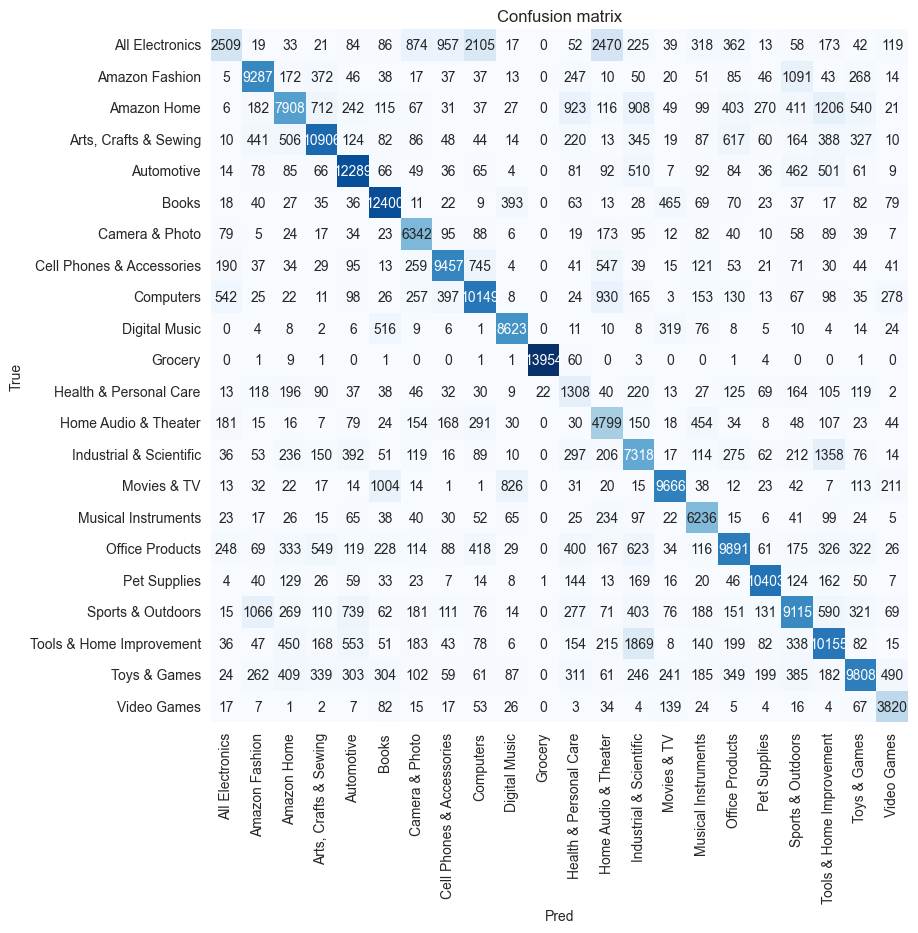

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=np.unique(y_test),
       yticklabels=np.unique(y_test), title="Confusion matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### Save model

In [19]:
# Save the model
dump(model, '../Models/embedding_fasttext.joblib')

['../Models/embedding_fasttext.joblib']

In [20]:
# Save tokenizer
dump(tokenizer, '../Models/tokenizer_embedding_fasttext.joblib')

['../Models/tokenizer_embedding_fasttext.joblib']